## Phishing Email Classifier: Feature Engineering, Logistic Regression, Cross Validation

Email classification. I want to eventually classify emails as phishing/spam emails or not, using features generated from the email's text.

Labeled training dataset: 8348 labeled examples. Test set contains 1000 unlabeled examples. Thanks to the UC Berkeley students who provided me with this dataset.


The train DataFrame contains labeled data that I will use to train the model. It contains four columns:

id: An identifier for the training example
subject: The subject of the email
email: The text of the email
values: 1 if the email is phishing, 0 if the email is legitimate

###Initial Analysis

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid",
        color_codes = True,
        font_scale = 1.5)

In [ ]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Thu Nov 28 13:04:06 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Thu Nov 28 13:04:08 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Missing values

In [ ]:
print("Number of NaN values in the id column is: ", original_training_data['id'].isna().sum())
print("Number of NaN values in the subject column is: ", original_training_data['subject'].isna().sum())
print("Number of NaN values in the email column is: ", original_training_data['email'].isna().sum())
print("Number of NaN values in the spam column is: ", original_training_data['spam'].isna().sum())

original_training_data = original_training_data.fillna('')

The number of NaN values in the id column is:  0
The number of NaN values in the subject column is:  6
The number of NaN values in the email column is:  0
The number of NaN values in the spam column is:  0


Viewing the fist few emails

In [ ]:
ham = original_training_data[original_training_data['spam']==0]
spam = original_training_data[original_training_data['spam']==1]

first_ham = ham.iloc[0,2]
first_spam = spam.iloc[0,2]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



## Training Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

As this is classificiation, I'll use a logistic regression mode and for this l we need a numeric feature matrix X and a vector of corresponding binary labels, y.  Since the data is text not numbers I can create numeric features from the email text and use those features for logistic regression.

In [ ]:
def words_in_texts(words, texts):
    '''
    Inputs:
        words (list-like): words to find
        texts (Series): strings to search in

    Outputs:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.array([])
    for email in texts:
        email_array = np.array([])
        for word in words:
            if word in email:
                email_array = np.append(email_array, 1)
            else:
                email_array = np.append(email_array, 0)
        indicator_array = np.append(indicator_array, email_array, axis = 0)
    indicator_array = np.reshape(indicator_array, (len(texts), len(words)))
    return indicator_array

In [ ]:
words_in_texts(['hello', 'bye', 'html'], pd.Series(['hello', 'hello</html>']))

array([[1., 0., 0.],
       [1., 0., 1.]])

# Basic EDA


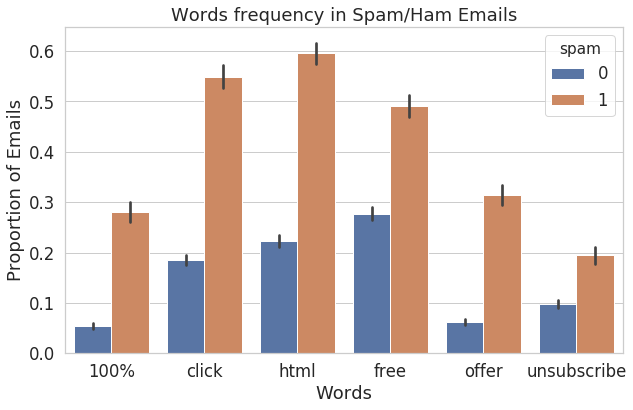

In [ ]:
train=train.reset_index(drop=True)
plt.figure(figsize = (10,6))
spam_words = ['100%', 'click', 'html', 'free', 'offer', 'unsubscribe']
by_word = words_in_texts(spam_words, train['email'])
by_word = pd.DataFrame(by_word)
by_word['spam'] = train['spam']
by_word = by_word.melt('spam')
sns.barplot(x = by_word['variable'], y = by_word['value'], hue = by_word['spam']).set(xticklabels=spam_words)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Words frequency in Spam/Ham Emails')
plt.show()

Text(0.5, 1.0, 'Length of Ham/Spam Emails')

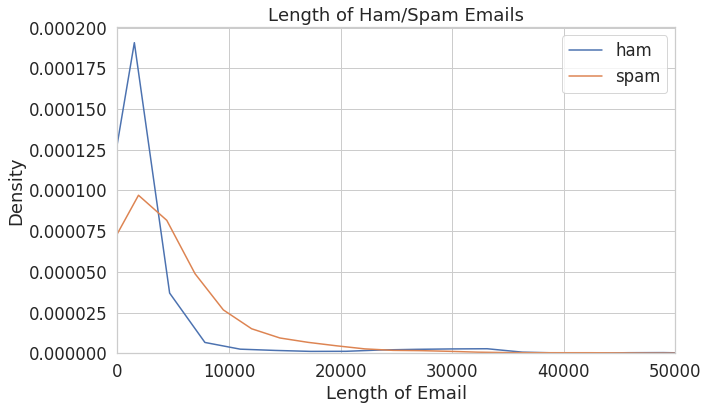

In [ ]:
train['length'] = train['email'].apply(len)
ham = train[train['spam']==0]
spam = train[train['spam']==1]
fig = plt.figure(figsize=(10,6))
sns.distplot(ham['length'], hist = False, label = 'ham').set(xlim = (0,50000))
sns.distplot(spam['length'], hist = False, label = 'spam').set(xlim = (0,50000))
plt.xlabel('Length of Email')
plt.ylabel('Density')
plt.title('Length of Ham/Spam Emails')

Since the output of `words_in_texts(words, train['email'])` is a numeric matrix with features for each email, we can use it to train a classifier.

In [ ]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']
X_train = words_in_texts(some_words, train['email']).astype(int)
Y_train = np.array(train['spam'])
X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0]))

Moving to scikit-learn, the logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False).fit(X_train, Y_train)
training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7584187408491947


## Evaluating Classifiers

Peventing errors -- false positive, false negatives etc

In [ ]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)

In [ ]:
zero_predictor_tp = 0
zero_predictor_tn = len(Y_train) - sum(Y_train)
n = len(Y_train)

zero_predictor_acc = zero_predictor_tn/n

zero_predictor_recall = 0
zero_predictor_acc

0.7447091707706642

In [ ]:
predicted = model.predict(X_train)

#1 -> 1
tp = sum(np.logical_and(Y_train, predicted))
#0 -> 0
tn = sum(np.logical_and(Y_train, np.invert(predicted)))
#0 -> 1
fp = sum((Y_train - predicted) < 0)
#1 -> 0
fn = sum((Y_train - predicted) > 0)


logistic_predictor_precision = tp/(tp+fp)
logistic_predictor_recall = tp/(tp+fn)
logistic_predictor_far = fp/(fp+tn)
print(logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far)

0.5948434622467772 0.1684045881126173 0.1028999064546305


### Improving model accuracy

In [ ]:
import re
from collections import Counter
import sklearn.linear_model as lm
import sklearn.metrics as sk


pd.set_option('display.max_rows', None)
training = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Feature engineering

In [ ]:
# proportion of uppercase letters in string
def caps(text):
    count = sum(1 for s in text if s.isupper())
    return count/len(text)

# count of special (non-word) letters in string
def special(text):
    count = len(re.sub('[\w]+', '', text))
    return count

# Returns 1 or 0 if 're' or 'fw' in subject line
def re_fw(text):
    match = re.search('^re|^fw', text.lower())
    if match:
        return 1
    return 0

#returns number of words in string
def num_words(text):
    return len(text.split())

def remove_stopwords(email):
    new_email = ''
    split = email.lower().split()
    for word in split:
        if word not in my_stopwords:
            new_email += word + ' '
    return new_email

my_stopwords = ['hers', 'between', 'yourself', 'but', 'again',
                'there', 'about', 'once', 'out', 'very', 'having',
                'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its',
                'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off',
                'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the',
                'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his',
                'through', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this',
                'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to',
                'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them',
                'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves',
                'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not',
                'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
                'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if',
                'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was',
                'here', 'than']

words = ['100%', 'click', 'html', 'offer', 'free', 'would', 'use',
         'guaranteed', 'deal', 'insurance', 'receive',
         'reply', 'bank', 'business', 'offer', 'url', 'thanks', 'name',
         'could', 'really', 'wrote:','think','still','really', 'date:']

clean/train/test

In [ ]:
def clean(data):
    data['e_cap'] = data['email'].astype(str).apply(caps)
    data['subject'] = data['subject'].str.replace('Subject: ', '')
    data['email'] = data['email'].apply(remove_stopwords)
    data['s_len'] = data['subject'].astype(str).apply(len)
    data['e_len'] = data['email'].astype(str).apply(len)
    data['s_cap'] = data['subject'].astype(str).apply(caps)
    data['s_special'] = data['subject'].astype(str).apply(special)
    data['e_special'] = data['email'].astype(str).apply(special)
    data['re_fw'] = data['subject'].astype(str).apply(re_fw)
    data['e_words'] = data['email'].astype(str).apply(num_words)
    word_df = pd.DataFrame(words_in_texts(words, data['email'].astype(str).str.lower()))
    word_df['id'] = data['id']
    data = data.merge(word_df, on = 'id')
    return data


training = clean(training)
test = clean(test)

In [ ]:
training.head()

,id,subject,email,spam,e_cap,s_len,e_len,s_cap,s_special,e_special,...,15,16,17,18,19,20,21,22,23,24
0,0,A&L Daily to be auctioned in bankruptcy\n,url: http://boingboing.net/#85534171 date: sup...,0,0.061281,40,285,0.075000,8,67,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,"Wired: ""Stronger ties between ISPs and file-tr...",url: http://scriptingnews.userland.com/backiss...,0,0.064748,62,253,0.080645,11,61,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,It's just too small HLOY\n,"<html> <head> </head> <body> <font size=3d""4"">...",1,0.114865,44,351,0.113636,25,109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,liberal defnitions\n,depends much spending vs. much (and type) regu...,0,0.017333,19,1043,0.000000,2,204,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,RE: [ILUG] Newbie seeks advice - Suse 7.2\n,hehe sorry hit caps lock twice computer crashe...,0,0.044599,42,1556,0.190476,13,337,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


Visualizing

In [ ]:
# Splitting data, pulling out word features
train, val = train_test_split(training, test_size=0.2, random_state=42)

spam = train[train['spam'] ==1]
ham = train[train['spam'] ==0]

spam_common = Counter(" ".join(spam["email"]).lower().split()).most_common(300)
ham_common = Counter(" ".join(ham["email"]).lower().split()).most_common(300)

only_spam = list(set(spam_common) - set(ham_common))

#spam_s_common = Counter(" ".join(spam["subject"].astype(str)).lower().split()).most_common(100)
#ham_s_common = Counter(" ".join(ham["subject"].astype(str)).lower().split()).most_common(100)

Text(0, 0.5, 'density')

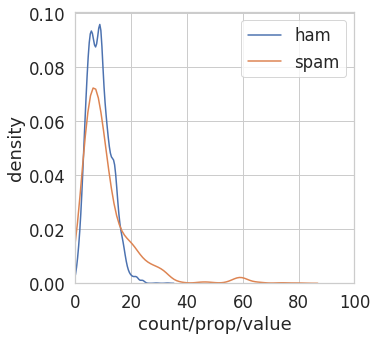

In [ ]:
# Plotting features
fig = plt.figure(figsize=(5,5))
sns.distplot(ham['s_special'], hist = False, label = 'ham').set(xlim = (0,100))
sns.distplot(spam['s_special'], hist = False, label = 'spam').set(xlim = (0,100))

plt.xlabel('count/prop/value')
plt.ylabel('density')

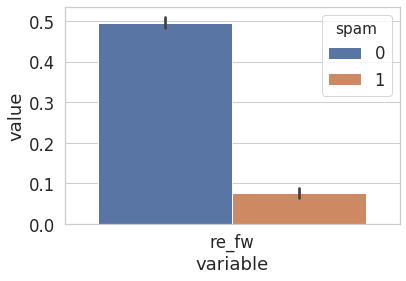

In [ ]:
# Plotting re_fw
bar = train[['spam', 're_fw']].melt('spam')
sns.barplot(x = bar['variable'], y = bar['value'], hue = bar['spam'])

In [ ]:
train.head()

,id,subject,email,spam,e_cap,s_len,e_len,s_cap,s_special,e_special,...,15,16,17,18,19,20,21,22,23,24
2181,2181,Re: Minor feature request\n,> easy would code menu item marks read message...,0,0.030837,26,1315,0.076923,5,315,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5515,5515,IP: The FCC NPRM on the Broadcast Flag\n,--- begin forwarded text delivered-to: ip-sub-...,0,0.051595,40,1133,0.300000,10,263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1153,1153,FW: FOCUS ON VALUE\n,<html><head><title></title><meta http-equiv=3d...,1,0.089938,19,6527,0.736842,5,1644,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
198,198,Re: Ximian apt repos?\n,"mon, 2002-07-22 06:50, che wrote: > thats corr...",0,0.027990,22,326,0.090909,6,63,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6844,6844,Re: [ILUG] cups question\n,zzzz@example.com (justin mason) writes: > /dev...,0,0.039715,25,779,0.200000,7,187,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

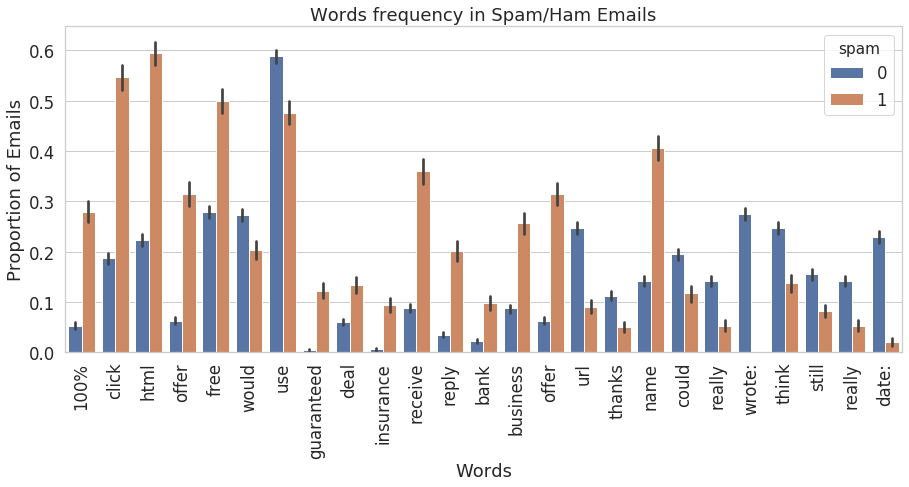

In [ ]:
# word features
plt.figure(figsize = (15,6))
word_df = train.iloc[:, 12:]
word_df['spam'] = train['spam']
word_df_melt = word_df.melt('spam')
sns.barplot(x = word_df_melt['variable'], y = word_df_melt['value'], hue = word_df_melt['spam']).set(xticklabels=words)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Words frequency in Spam/Ham Emails')
plt.xticks(rotation = 'vertical')

##Training Model

In [ ]:
model = lm.LogisticRegression()
X_train = training.iloc[:, 4:]
Y_train = training['spam']
X_val = val.iloc[:, 4:]
Y_val = val['spam']
X_test = test.iloc[:, 3:]

model.fit(X_train, Y_train)
prediction = model.predict(X_val)
prediction1 = model.predict(X_train)

print(sk.accuracy_score(Y_val, prediction), sk.accuracy_score(Y_train, prediction1))

0.9395209580838323 0.9335170100622904
